<a href="https://colab.research.google.com/github/IanEdington/learn/blob/master/machine-learning/ggl-mlcc/intro_to_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [0]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [0]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [0]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [0]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,weight,engine-type,num-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.80,192.70,71.40,55.90,3086,ohc,five,131,mpfi,3.13,3.40,8.30,140,5500,17,20,23875
132,3,150,saab,gas,std,two,hatchback,fwd,front,99.10,186.60,66.50,56.10,2658,ohc,four,121,mpfi,3.54,3.07,9.31,110,5250,21,28,11850
170,2,134,toyota,gas,std,two,hardtop,rwd,front,98.40,176.20,65.60,52.00,2679,ohc,four,146,mpfi,3.62,3.50,9.30,116,4800,24,30,11199


c:  symboling  		 type:  <class 'numpy.int64'>
c:  normalized-losses  		 type:  <class 'str'>
c:  make  		 type:  <class 'str'>
c:  fuel-type  		 type:  <class 'str'>
c:  aspiration  		 type:  <class 'str'>
c:  num-doors  		 type:  <class 'str'>
c:  body-style  		 type:  <class 'str'>
c:  drive-wheels  		 type:  <class 'str'>
c:  engine-location  		 type:  <class 'str'>
c:  wheel-base  		 type:  <class 'numpy.float64'>
c:  length  		 type:  <class 'numpy.float64'>
c:  width  		 type:  <class 'numpy.float64'>
c:  height  		 type:  <class 'numpy.float64'>
c:  weight  		 type:  <class 'numpy.int64'>
c:  engine-type  		 type:  <class 'str'>
c:  num-cylinders  		 type:  <class 'str'>
c:  engine-size  		 type:  <class 'numpy.int64'>
c:  fuel-system  		 type:  <class 'str'>
c:  bore  		 type:  <class 'str'>
c:  stroke  		 type:  <class 'str'>
c:  compression-ratio  		 type:  <class 'numpy.float64'>
c:  horsepower  		 type:  <class 'str'>
c:  peak-rpm  		 type:  <class 'str'>
c:  city-mpg  		 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd872bbdfd0>,
      dtype=object)

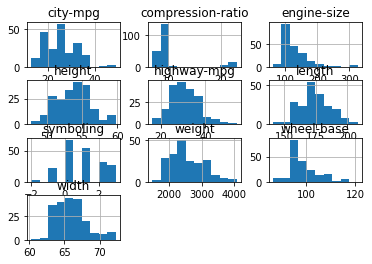

In [0]:
for c in car_data.columns:
  print("c: ", c, " \t\t type: ", type(car_data[c][1]))
car_data.hist()

In [0]:
numeric_feature_names = []
categorical_feature_names = []

In [0]:
def look_at_feature(feature):
  feature.hist()
  print(feature.head())
  print(feature.tail())
  return feature.describe()

In [0]:
for c in car_data.columns:
  print(f"look_at_feature(car_data[\"{c}\"])")

look_at_feature(car_data["symboling"])
look_at_feature(car_data["normalized-losses"])
look_at_feature(car_data["make"])
look_at_feature(car_data["fuel-type"])
look_at_feature(car_data["aspiration"])
look_at_feature(car_data["num-doors"])
look_at_feature(car_data["body-style"])
look_at_feature(car_data["drive-wheels"])
look_at_feature(car_data["engine-location"])
look_at_feature(car_data["wheel-base"])
look_at_feature(car_data["length"])
look_at_feature(car_data["width"])
look_at_feature(car_data["height"])
look_at_feature(car_data["weight"])
look_at_feature(car_data["engine-type"])
look_at_feature(car_data["num-cylinders"])
look_at_feature(car_data["engine-size"])
look_at_feature(car_data["fuel-system"])
look_at_feature(car_data["bore"])
look_at_feature(car_data["stroke"])
look_at_feature(car_data["compression-ratio"])
look_at_feature(car_data["horsepower"])
look_at_feature(car_data["peak-rpm"])
look_at_feature(car_data["city-mpg"])
look_at_feature(car_data["highway-mpg"])
look_at_feat

77     2
48     0
180   -1
56     3
8      1
Name: symboling, dtype: int64
94     1
62     0
155    0
80     3
130    0
Name: symboling, dtype: int64


count   205.00
mean      0.83
std       1.25
min      -2.00
25%       0.00
50%       1.00
75%       2.00
max       3.00
Name: symboling, dtype: float64

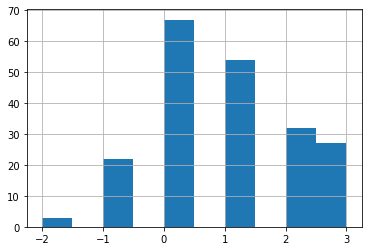

In [0]:
numeric_feature_names.append("symboling")
look_at_feature(car_data["symboling"])

77     161
48       ?
180     90
56     150
8      158
Name: normalized-losses, dtype: object
94     128
62     115
155     91
80     153
130      ?
Name: normalized-losses, dtype: object


count     205
unique     52
top         ?
freq       41
Name: normalized-losses, dtype: object

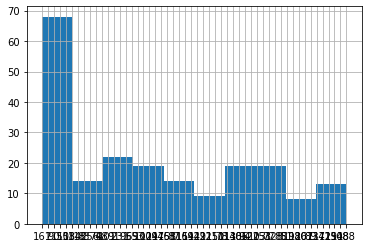

In [0]:
numeric_feature_names.append("normalized-losses")
look_at_feature(car_data["normalized-losses"])

77     mitsubishi
48         jaguar
180        toyota
56          mazda
8            audi
Name: make, dtype: object
94         nissan
62          mazda
155        toyota
80     mitsubishi
130       renault
Name: make, dtype: object


count        205
unique        22
top       toyota
freq          32
Name: make, dtype: object

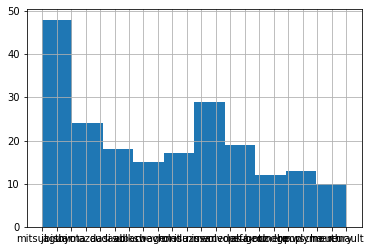

In [0]:
categorical_feature_names.append("make")
look_at_feature(car_data["make"])


77     gas
48     gas
180    gas
56     gas
8      gas
Name: fuel-type, dtype: object
94     gas
62     gas
155    gas
80     gas
130    gas
Name: fuel-type, dtype: object


count     205
unique      2
top       gas
freq      185
Name: fuel-type, dtype: object

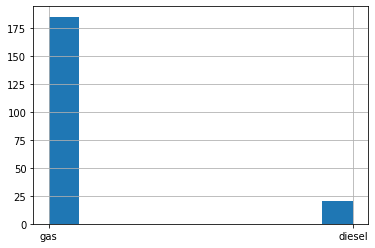

In [0]:
categorical_feature_names.append("fuel-type")

look_at_feature(car_data["fuel-type"])


77       std
48       std
180      std
56       std
8      turbo
Name: aspiration, dtype: object
94       std
62       std
155      std
80     turbo
130      std
Name: aspiration, dtype: object


count     205
unique      2
top       std
freq      168
Name: aspiration, dtype: object

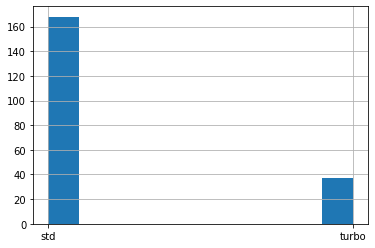

In [0]:
categorical_feature_names.append("aspiration")

look_at_feature(car_data["aspiration"])


77      two
48     four
180    four
56      two
8      four
Name: num-doors, dtype: object
94      two
62     four
155    four
80      two
130    four
Name: num-doors, dtype: object


count      205
unique       3
top       four
freq       114
Name: num-doors, dtype: object

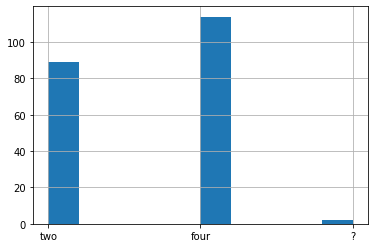

In [0]:
categorical_feature_names.append("num-doors")

look_at_feature(car_data["num-doors"])


77     hatchback
48         sedan
180        sedan
56     hatchback
8          sedan
Name: body-style, dtype: object
94         sedan
62         sedan
155        wagon
80     hatchback
130        wagon
Name: body-style, dtype: object


count       205
unique        5
top       sedan
freq         96
Name: body-style, dtype: object

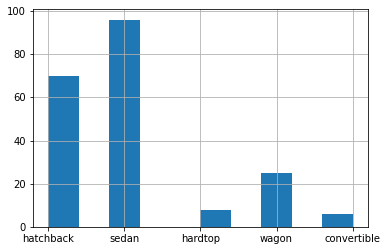

In [0]:
categorical_feature_names.append("body-style")
look_at_feature(car_data["body-style"])


77     fwd
48     rwd
180    rwd
56     rwd
8      fwd
Name: drive-wheels, dtype: object
94     fwd
62     fwd
155    4wd
80     fwd
130    fwd
Name: drive-wheels, dtype: object


count     205
unique      3
top       fwd
freq      120
Name: drive-wheels, dtype: object

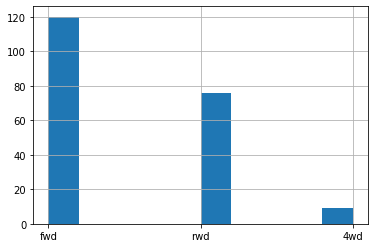

In [0]:
categorical_feature_names.append("drive-wheels")

look_at_feature(car_data["drive-wheels"])


77     front
48     front
180    front
56     front
8      front
Name: engine-location, dtype: object
94     front
62     front
155    front
80     front
130    front
Name: engine-location, dtype: object


count       205
unique        2
top       front
freq        202
Name: engine-location, dtype: object

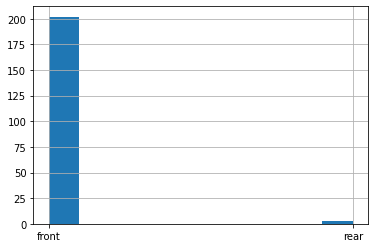

In [0]:
categorical_feature_names.append("engine-locations")

look_at_feature(car_data["engine-location"])


77     93.70
48    113.00
180   104.50
56     95.30
8     105.80
Name: wheel-base, dtype: float64
94    94.50
62    98.80
155   95.70
80    96.30
130   96.10
Name: wheel-base, dtype: float64


count   205.00
mean     98.76
std       6.02
min      86.60
25%      94.50
50%      97.00
75%     102.40
max     120.90
Name: wheel-base, dtype: float64

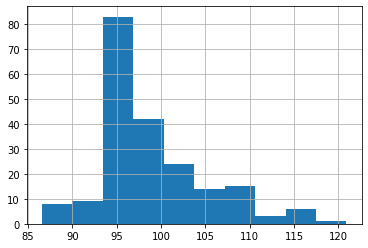

In [0]:

numeric_feature_names.append("wheel-bases")
look_at_feature(car_data["wheel-base"])


77    157.30
48    199.60
180   187.80
56    169.00
8     192.70
Name: length, dtype: float64
94    165.30
62    177.80
155   169.70
80    173.00
130   181.50
Name: length, dtype: float64


count   205.00
mean    174.05
std      12.34
min     141.10
25%     166.30
50%     173.20
75%     183.10
max     208.10
Name: length, dtype: float64

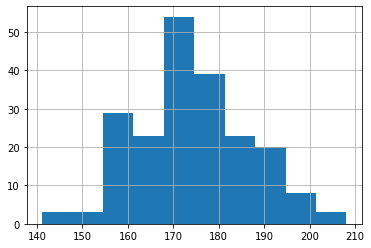

In [0]:

numeric_feature_names.append("length")
look_at_feature(car_data["length"])


77    64.40
48    69.60
180   66.50
56    65.70
8     71.40
Name: width, dtype: float64
94    63.80
62    66.50
155   63.60
80    65.40
130   66.50
Name: width, dtype: float64


count   205.00
mean     65.91
std       2.15
min      60.30
25%      64.10
50%      65.50
75%      66.90
max      72.30
Name: width, dtype: float64

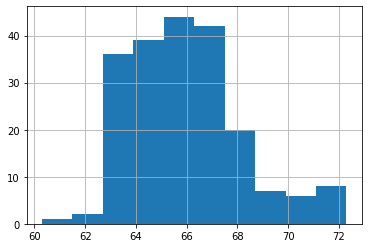

In [0]:

numeric_feature_names.append("width")
look_at_feature(car_data["width"])


77    50.80
48    52.80
180   54.10
56    49.60
8     55.90
Name: height, dtype: float64
94    54.50
62    55.50
155   59.10
80    49.40
130   55.20
Name: height, dtype: float64


count   205.00
mean     53.72
std       2.44
min      47.80
25%      52.00
50%      54.10
75%      55.50
max      59.80
Name: height, dtype: float64

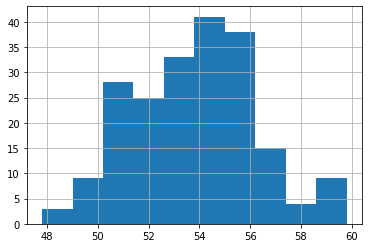

In [0]:

numeric_feature_names.append("height")
look_at_feature(car_data["height"])


77     1944
48     4066
180    3131
56     2380
8      3086
Name: weight, dtype: int64
94     1951
62     2410
155    3110
80     2370
130    2579
Name: weight, dtype: int64


count    205.00
mean    2555.57
std      520.68
min     1488.00
25%     2145.00
50%     2414.00
75%     2935.00
max     4066.00
Name: weight, dtype: float64

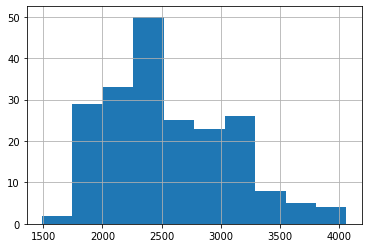

In [0]:

numeric_feature_names.append("weight")
look_at_feature(car_data["weight"])


77       ohc
48      dohc
180     dohc
56     rotor
8        ohc
Name: engine-type, dtype: object
94     ohc
62     ohc
155    ohc
80     ohc
130    ohc
Name: engine-type, dtype: object


count     205
unique      7
top       ohc
freq      148
Name: engine-type, dtype: object

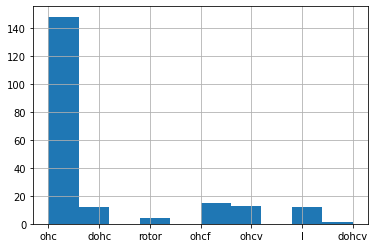

In [0]:

categorical_feature_names.append("engine-type")
look_at_feature(car_data["engine-type"])


77     four
48      six
180     six
56      two
8      five
Name: num-cylinders, dtype: object
94     four
62     four
155    four
80     four
130    four
Name: num-cylinders, dtype: object


count      205
unique       7
top       four
freq       159
Name: num-cylinders, dtype: object

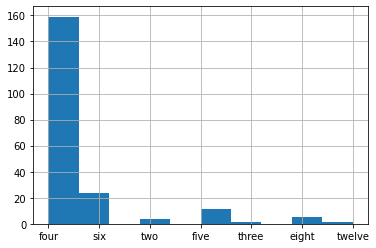

In [0]:

categorical_feature_names.append("num-cylinders")
look_at_feature(car_data["num-cylinders"])


77      92
48     258
180    171
56      70
8      131
Name: engine-size, dtype: int64
94      97
62     122
155     92
80     110
130    132
Name: engine-size, dtype: int64


count   205.00
mean    126.91
std      41.64
min      61.00
25%      97.00
50%     120.00
75%     141.00
max     326.00
Name: engine-size, dtype: float64

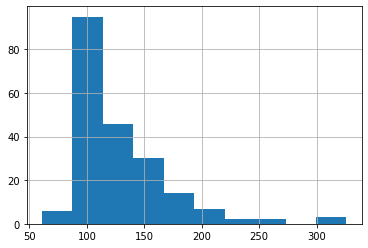

In [0]:

numeric_feature_names.append("engine-size")
look_at_feature(car_data["engine-size"])


77     2bbl
48     mpfi
180    mpfi
56     4bbl
8      mpfi
Name: fuel-system, dtype: object
94     2bbl
62     2bbl
155    2bbl
80     spdi
130    mpfi
Name: fuel-system, dtype: object


count      205
unique       8
top       mpfi
freq        94
Name: fuel-system, dtype: object

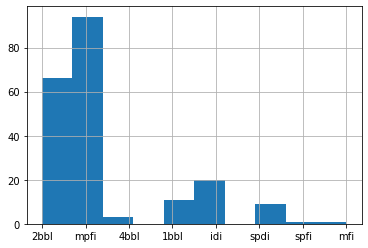

In [0]:

categorical_feature_names.append("fuel-system")
look_at_feature(car_data["fuel-system"])


77     2.97
48     3.63
180    3.27
56        ?
8      3.13
Name: bore, dtype: object
94     3.15
62     3.39
155    3.05
80     3.17
130    3.46
Name: bore, dtype: object


count      205
unique      39
top       3.62
freq        23
Name: bore, dtype: object

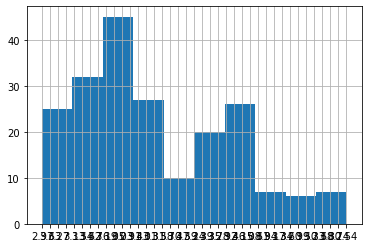

In [0]:

numeric_feature_names.append("bore")
look_at_feature(car_data["bore"])


77     3.23
48     4.17
180    3.35
56        ?
8      3.40
Name: stroke, dtype: object
94     3.29
62     3.39
155    3.03
80     3.46
130    3.90
Name: stroke, dtype: object


count      205
unique      37
top       3.40
freq        20
Name: stroke, dtype: object

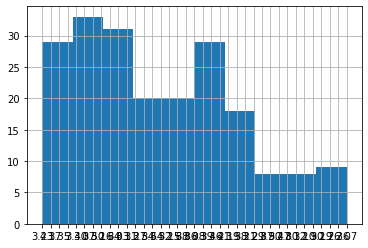

In [0]:

numeric_feature_names.append("stroke")
look_at_feature(car_data["stroke"])


77    9.40
48    8.10
180   9.20
56    9.40
8     8.30
Name: compression-ratio, dtype: float64
94    9.40
62    8.60
155   9.00
80    7.50
130   8.70
Name: compression-ratio, dtype: float64


count   205.00
mean     10.14
std       3.97
min       7.00
25%       8.60
50%       9.00
75%       9.40
max      23.00
Name: compression-ratio, dtype: float64

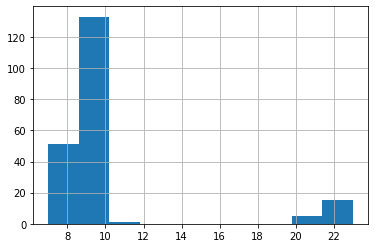

In [0]:

numeric_feature_names.append("compression-ratio")
look_at_feature(car_data["compression-ratio"])


77      68
48     176
180    156
56     101
8      140
Name: horsepower, dtype: object
94      69
62      84
155     62
80     116
130      ?
Name: horsepower, dtype: object


count     205
unique     60
top        68
freq       19
Name: horsepower, dtype: object

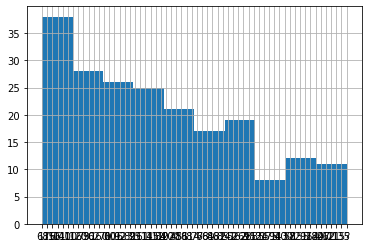

In [0]:

numeric_feature_names.append("horsepower")
look_at_feature(car_data["horsepower"])


77     5500
48     4750
180    5200
56     6000
8      5500
Name: peak-rpm, dtype: object
94     5200
62     4800
155    4800
80     5500
130       ?
Name: peak-rpm, dtype: object


count      205
unique      24
top       5500
freq        37
Name: peak-rpm, dtype: object

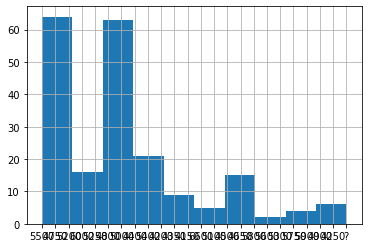

In [0]:

numeric_feature_names.append("peak-rpm")
look_at_feature(car_data["peak-rpm"])


77     31
48     15
180    20
56     17
8      17
Name: city-mpg, dtype: int64
94     31
62     26
155    27
80     23
130    23
Name: city-mpg, dtype: int64


count   205.00
mean     25.22
std       6.54
min      13.00
25%      19.00
50%      24.00
75%      30.00
max      49.00
Name: city-mpg, dtype: float64

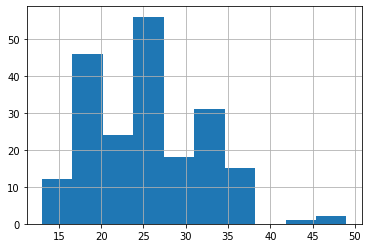

In [0]:

numeric_feature_names.append("city-mpg")
look_at_feature(car_data["city-mpg"])

77     38
48     19
180    24
56     23
8      20
Name: highway-mpg, dtype: int64
94     37
62     32
155    32
80     30
130    31
Name: highway-mpg, dtype: int64


count   205.00
mean     30.75
std       6.89
min      16.00
25%      25.00
50%      30.00
75%      34.00
max      54.00
Name: highway-mpg, dtype: float64

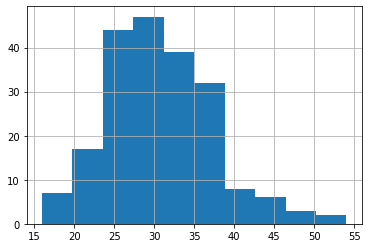

In [0]:
numeric_feature_names.append("highway-mpg")
look_at_feature(car_data["highway-mpg"])


In [0]:
print(numeric_feature_names)
print(len(numeric_feature_names))
print(categorical_feature_names)
print(len(categorical_feature_names))
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

['symboling', 'normalized-losses', 'wheel-bases', 'length', 'width', 'height', 'weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']
15
['make', 'fuel-type', 'aspiration', 'num-doors', 'body-style', 'drive-wheels', 'engine-locations', 'engine-type', 'num-cylinders', 'fuel-system']
10


In [0]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
LABEL = "price"
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [0]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
77,2,161,93.70,157.30,64.40,50.80,1944,92,68,5500,31,38,2.97,3.23,9.40
48,0,?,113.00,199.60,69.60,52.80,4066,258,176,4750,15,19,3.63,4.17,8.10
180,-1,90,104.50,187.80,66.50,54.10,3131,171,156,5200,20,24,3.27,3.35,9.20
56,3,150,95.30,169.00,65.70,49.60,2380,70,101,6000,17,23,?,?,9.40
8,1,158,105.80,192.70,71.40,55.90,3086,131,140,5500,17,20,3.13,3.40,8.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1,128,94.50,165.30,63.80,54.50,1951,97,69,5200,31,37,3.15,3.29,9.40
62,0,115,98.80,177.80,66.50,55.50,2410,122,84,4800,26,32,3.39,3.39,8.60
155,0,91,95.70,169.70,63.60,59.10,3110,92,62,4800,27,32,3.05,3.03,9.00
80,3,153,96.30,173.00,65.40,49.40,2370,110,116,5500,23,30,3.17,3.46,7.50


In [0]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,make,fuel-type,engine-type,num-doors,engine-location,fuel-system,num-cylinders,body-style,drive-wheels,aspiration
77,mitsubishi,gas,ohc,two,front,2bbl,four,hatchback,fwd,std
48,jaguar,gas,dohc,four,front,mpfi,six,sedan,rwd,std
180,toyota,gas,dohc,four,front,mpfi,six,sedan,rwd,std
56,mazda,gas,rotor,two,front,4bbl,two,hatchback,rwd,std
8,audi,gas,ohc,four,front,mpfi,five,sedan,fwd,turbo
...,...,...,...,...,...,...,...,...,...,...
94,nissan,gas,ohc,two,front,2bbl,four,sedan,fwd,std
62,mazda,gas,ohc,four,front,2bbl,four,sedan,fwd,std
155,toyota,gas,ohc,four,front,2bbl,four,wagon,4wd,std
80,mitsubishi,gas,ohc,two,front,spdi,four,hatchback,fwd,turbo


In [0]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [0]:
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=

In [0]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfm785xxd/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


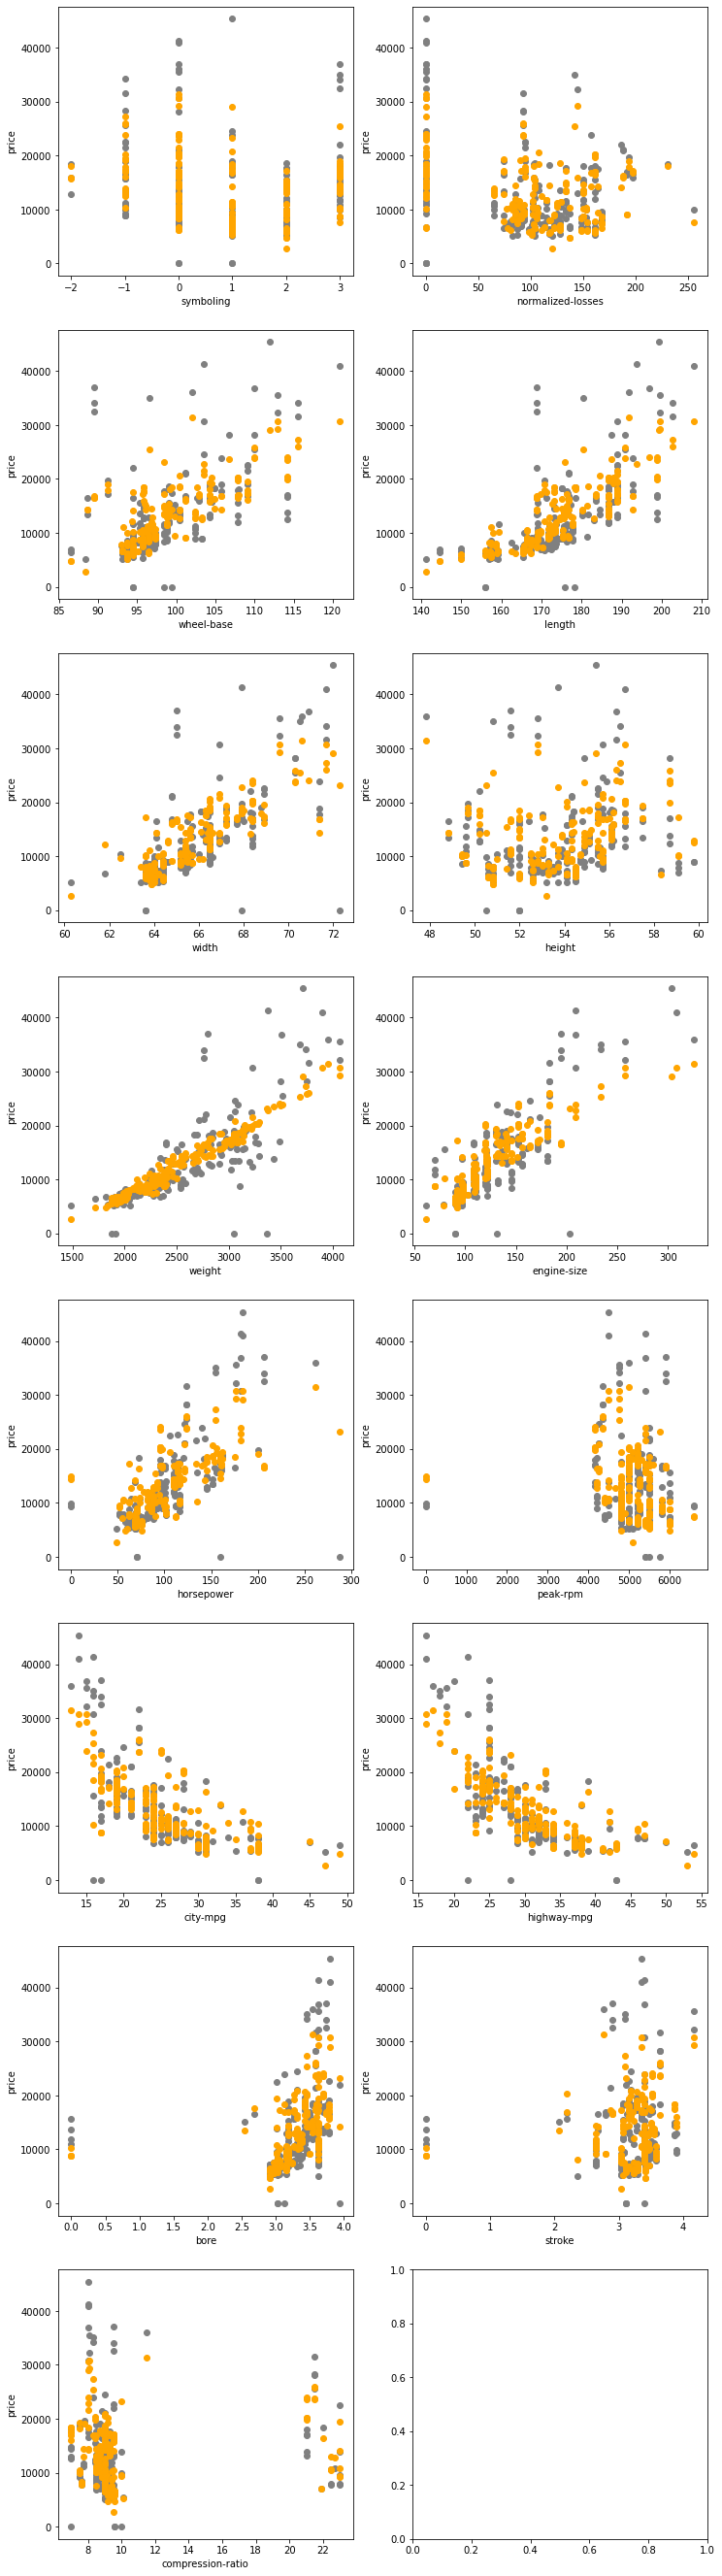

In [0]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 2
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 6
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

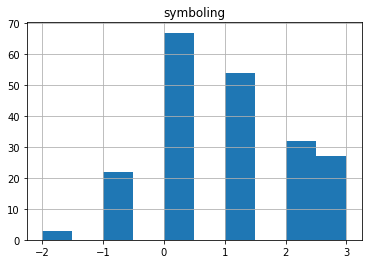

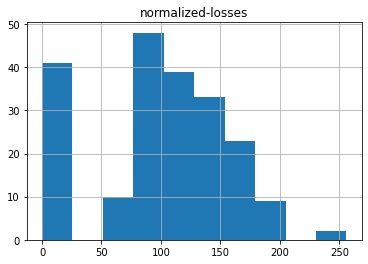

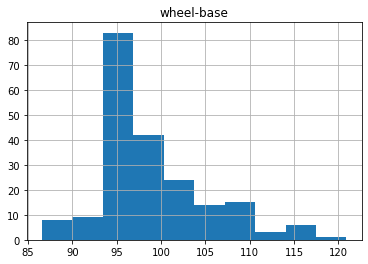

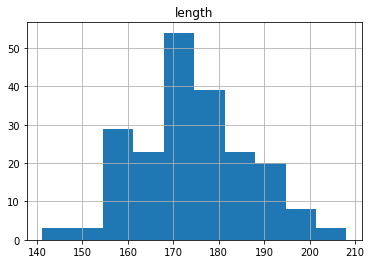

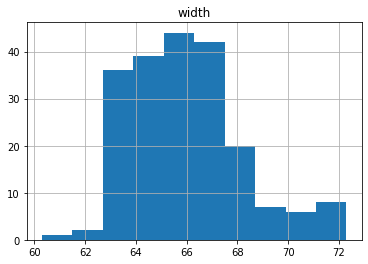

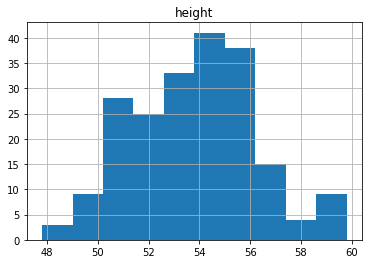

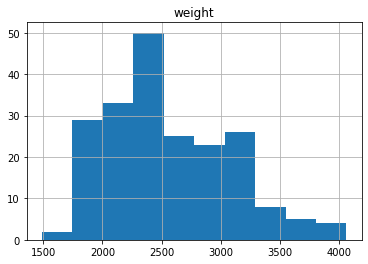

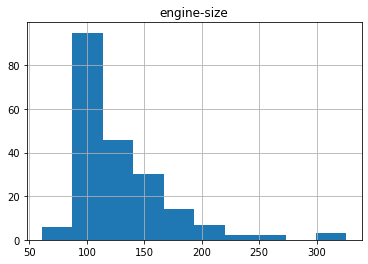

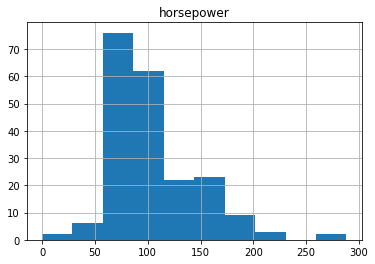

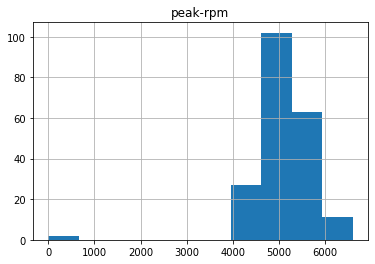

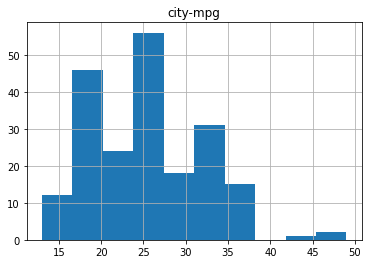

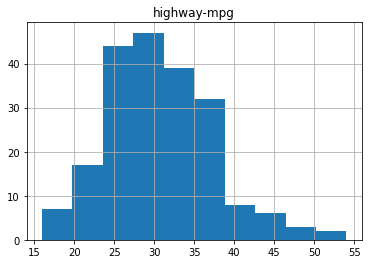

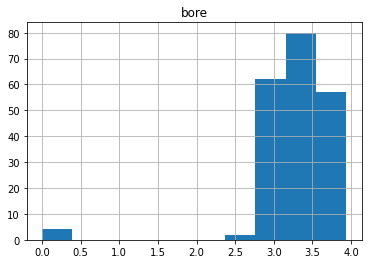

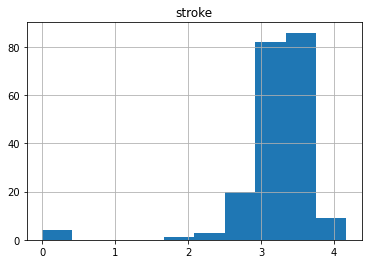

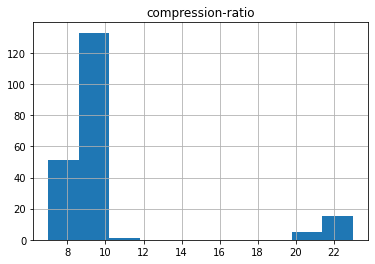

In [0]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [0]:
def make_score_plot(all_scores):
  # get data in right format
  # could add a sort by x_label but we'll trust the data for now
  x_label = "global_step"
  x = [scores["global_step"] for scores in all_scores]
  y_labels = [key for key in all_scores[0]]
  y_labels.remove("global_step")
  y_s = {
      label: [scores[label] for scores in all_scores]
      for label in y_labels
  }

  y_s["average_loss"] = [x/(10**6) for x in y_s["average_loss"]]
  plt.plot(x, y_s["average_loss"], label = "average_loss" + " (/10^6)")

  y_s["loss"] = [x/(10**7) for x in y_s["loss"]]
  plt.plot(x, y_s["loss"], label = "loss" + " (/10^7)")

  for label, stats in y_s.items():
    print(label)
    print(stats)
  
  # plt.xlabel('x - axis')
  # plt.ylabel('y - axis')
  plt.title('scores')
  plt.legend()

Start by normalizing all feature using their Z-scores

think about
- bucketting (symboling?)
- using mean for nulls
- non linear relationships (plot price vs feature)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd866875f28>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd86a316e18>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd86a316bf8>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd86a316d90>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd86a316d08>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

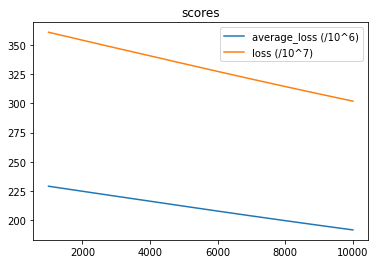

In [108]:
batch_size = 16
means = car_data.mean()[numeric_feature_names]
stds = car_data.std()[numeric_feature_names]

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / stds[feature_name]

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpivt0c7kv/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


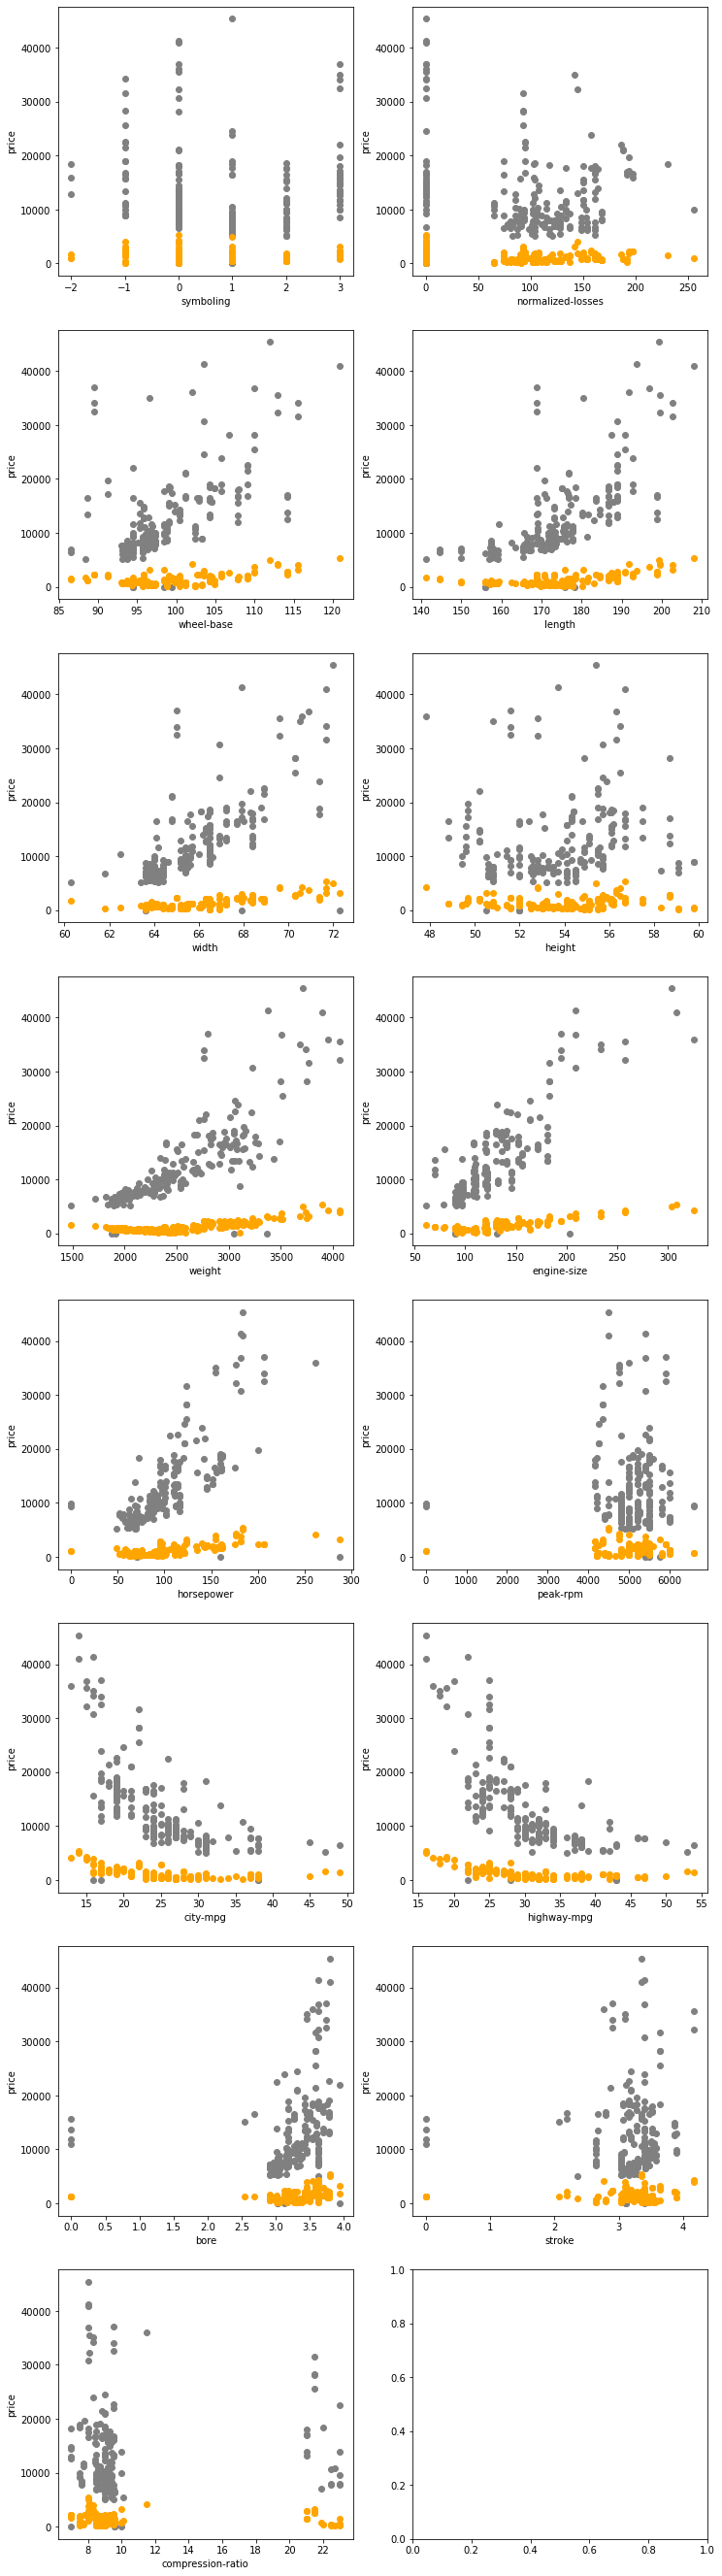

In [109]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [0]:
transformed = (car_data['length'] - means['length'] ) / stds['length']
print(transformed.describe())
transformed

count   205.00
mean     -0.00
std       1.00
min      -2.67
25%      -0.63
50%      -0.07
75%       0.73
max       2.76
Name: length, dtype: float64


77    -1.36
48     2.07
180    1.11
56    -0.41
8      1.51
       ... 
94    -0.71
62     0.30
155   -0.35
80    -0.09
130    0.60
Name: length, Length: 205, dtype: float64

In [0]:
# There's an issue with this model
# I didn't add an epsilon to avoid divide by zero
# how can I see in the data that this has happend?

# div_by_0 = car_data['length'] / 0
# print(div_by_0)

# divide by zero causes `inf` in pandas. This would cause a LOT of squew!

# why didn't I see this when using describe?

# print(div_by_0.describe())

transform_all_numberic_features = (x_df - means) / stds
print(transform_all_numberic_features)
transform_all_numberic_features.describe()

# based on the describe feature it doesn't seem like there are any inf cause by
# not including epsilon = 0.000001
# I would expect adding epsilon not to make a difference to the model

     symboling  normalized-losses  wheel-base  ...  bore  stroke  compression-ratio
77        0.94               1.09       -0.84  ... -0.55    0.07              -0.19
48       -0.67              -1.67        2.37  ...  0.68    1.78              -0.51
180      -1.47              -0.13        0.95  ...  0.01    0.29              -0.24
56        1.74               0.90       -0.57  ... -6.10   -5.81              -0.19
8         0.13               1.04        1.17  ... -0.25    0.38              -0.46
..         ...                ...         ...  ...   ...     ...                ...
94        0.13               0.52       -0.71  ... -0.21    0.18              -0.19
62       -0.67               0.30        0.01  ...  0.23    0.36              -0.39
155      -0.67              -0.11       -0.51  ... -0.40   -0.29              -0.29
80        1.74               0.95       -0.41  ... -0.18    0.49              -0.67
130      -0.67              -1.67       -0.44  ...  0.36    1.29            

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.28,-1.67,-2.02,-2.67,-2.61,-2.42,-2.05,-1.58,-2.53,-7.31,-1.87,-2.14,-6.10,-5.81,-0.79
25%,-0.67,-0.35,-0.71,-0.63,-0.84,-0.71,-0.79,-0.72,-0.81,-0.40,-0.95,-0.84,-0.25,-0.17,-0.39
50%,0.13,0.09,-0.29,-0.07,-0.19,0.15,-0.27,-0.17,-0.20,0.18,-0.19,-0.11,0.08,0.18,-0.29
75%,0.94,0.68,0.61,0.73,0.46,0.73,0.73,0.34,0.31,0.61,0.73,0.47,0.59,0.40,-0.19
max,1.74,2.72,3.68,2.76,2.98,2.49,2.90,4.78,4.52,2.19,3.63,3.38,1.26,1.78,3.24


model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd866875620>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd8668757b8>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd86f5d1840>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd86f5d1510>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7fd86aa57b70>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

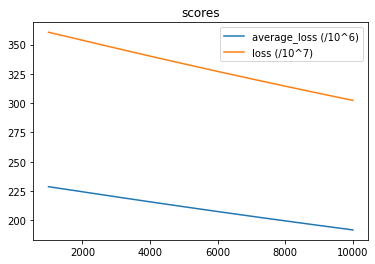

In [110]:
batch_size = 16
means = car_data.mean()[numeric_feature_names]
stds = car_data.std()[numeric_feature_names]

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (stds[feature_name]+0.00001)

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp79hhld_m/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


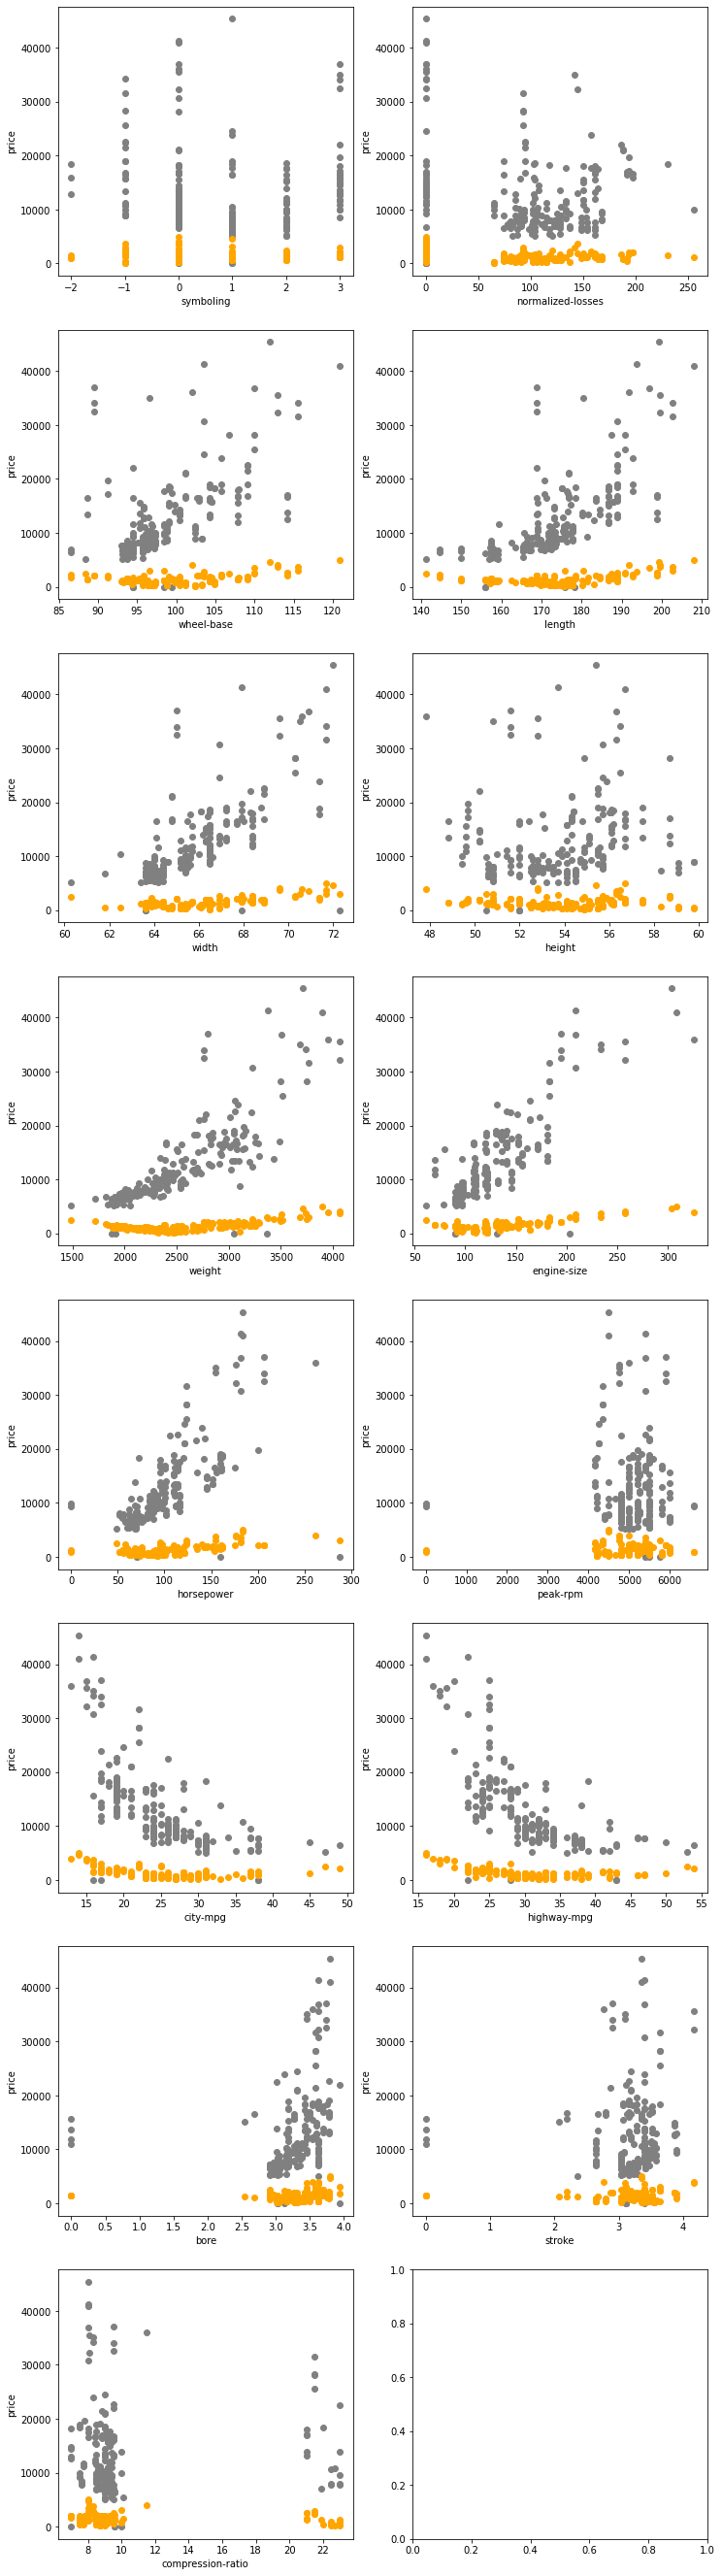

In [111]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [123]:
# epsilon is good to remember but it doesn't look like it wasn't the issue

# How would I know if there was an inf in my data set?


means_length = (x_df['length'] - means['length']) / stds['length']
means_length[0] /= 0
means_length.describe()
# if there was an `inf` it would show up in the describe
# takehomes
# 1. use the describe when making transformations, easy way to catch a mistake
# 2. div by zero is DANGEROUS!!! Common Ian, why don't you remember that!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


count   205.00
mean      -inf
std        nan
min       -inf
25%      -0.63
50%      -0.07
75%       0.73
max       2.76
Name: length, dtype: float64

In [0]:
# TODO What is the next thing my error could be caused by?

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7fd86f5957b8>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7fd86f595c80>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7fd86f595d08>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7fd86f58d048>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7fd86f58d0d0>), NumericColumn(key='height', shape=(1,), default_va

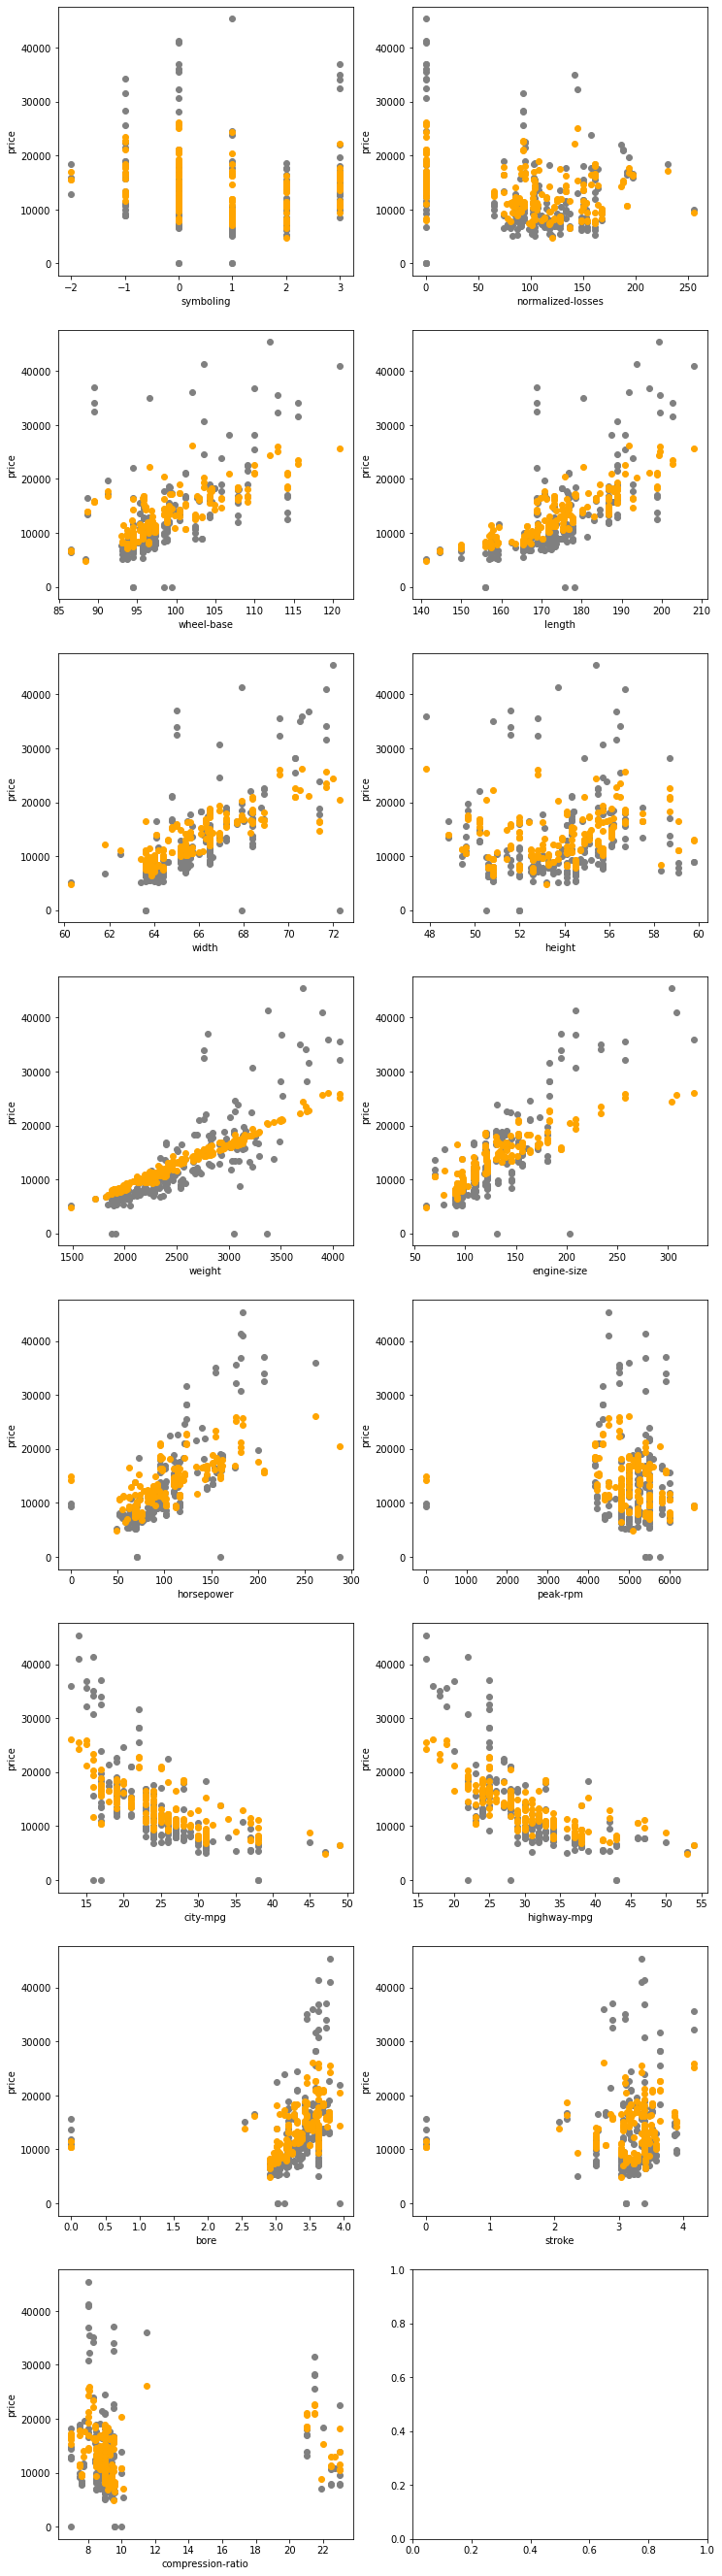

In [0]:
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [0]:
## Your code goes here

In [0]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('mitsubishi', 'jaguar', 'toyota', 'mazda', 'audi', 'saab', 'subaru', 'volkswagen', 'chevrolet', 'honda', 'isuzu', 'nissan', 'volvo', 'mercedes-benz', 'peugot', 'alfa-romero', 'dodge', 'bmw', 'porsche', 'plymouth', 'mercury', 'renault'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'dohc', 'rotor', 'ohcf', 'ohcv', 'l', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categ

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [0]:
## Your code goes here

In [0]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('mitsubishi', 'jaguar', 'toyota', 'mazda', 'audi', 'saab', 'subaru', 'volkswagen', 'chevrolet', 'honda', 'isuzu', 'nissan', 'volvo', 'mercedes-benz', 'peugot', 'alfa-romero', 'dodge', 'bmw', 'porsche', 'plymouth', 'mercury', 'renault'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'dohc', 'rotor', 'ohcf', 'ohcv', 'l', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categ

KeyboardInterrupt: ignored